In [169]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

In [179]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.python.keras import metrics

In [45]:
rawData = pd.read_csv('toyData.csv', sep=',')
rawData.head()

,Price,AllFuelsGen,NatGasGen,HydroGen,RenewablesGen,GDP,AvgTemp,AvgRelHum,NatGasPrice,TotElecNetGen,TotNatGasCons,TotRetailElecSales
0,11.07,14657.59,7418.12,1685.15,1689.59,1627.98,52.57,54.51,3.90,305.50,2120.20,19959.27
1,11.32,14591.10,6687.45,2515.53,1812.00,1631.46,54.04,47.27,3.79,319.94,2487.64,19863.79
2,11.17,12655.47,5888.04,1920.92,1626.95,1634.93,59.60,38.86,3.76,281.83,2242.43,17781.30
3,11.35,15788.66,7704.10,2452.48,1933.86,1638.40,55.29,51.49,3.84,302.55,2258.43,18227.13
4,10.99,13995.83,5634.56,2913.90,1895.40,1641.88,57.28,70.29,4.21,289.85,1880.99,18614.31


In [51]:
shiftMonths = 24

In [52]:
dfTargets = rawData.shift(-shiftMonths)

In [53]:
dfTargets.head()

,Price,AllFuelsGen,NatGasGen,HydroGen,RenewablesGen,GDP,AvgTemp,AvgRelHum,NatGasPrice,TotElecNetGen,TotNatGasCons,TotRetailElecSales
0,11.26,15249.50,7152.61,2479.54,1897.01,1745.04,54.23,45.68,5.89,331.68,2263.66,20861.67
1,11.08,15284.73,7165.57,2741.77,1807.98,1752.36,54.91,45.74,6.41,346.55,2675.83,20188.61
2,11.41,14469.30,7261.82,2509.35,1768.38,1930.88,51.61,54.76,6.35,314.28,2511.10,17876.56
3,10.98,15867.47,7721.33,3562.45,1932.44,1766.98,64.09,53.14,6.23,308.81,2100.92,19782.73
4,10.23,15347.64,7544.69,3441.20,1948.85,1774.29,61.91,60.70,6.31,290.56,1745.17,19642.47


In [58]:
xData = rawData.values[0:-shiftMonths]

In [59]:
print(type(xData))
print("Shape:", xData.shape)

<class 'numpy.ndarray'>
Shape: (146, 12)


In [62]:
yData = dfTargets.values[:-shiftMonths,0]

In [63]:
print(type(yData))
print("Shape:", yData.shape)

<class 'numpy.ndarray'>
Shape: (146,)


In [81]:
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(xData, yData, test_size=0.20, random_state=0)
print ('Number of samples in training data:',len(xTrain))
print ('Number of samples in test data:',len(xTest))

Number of samples in training data: 116
Number of samples in test data: 30


In [66]:
xScaler = MinMaxScaler()

In [67]:
xTrainScaled = xScaler.fit_transform(xTrain)

In [68]:
print("Min:", np.min(xTrainScaled))
print("Max:", np.max(xTrainScaled))

Min: 0.0
Max: 1.0000000000000004


In [69]:
xTestScaled = xScaler.transform(xTest)

In [84]:
yTrain = yTrain.reshape(-1,1)
yTest = yTest.reshape(-1,1)

In [86]:
yScaler = MinMaxScaler()
yTrainScaled = yScaler.fit_transform(yTrain)
yTestScaled = yScaler.transform(yTest)

In [87]:
print(xTrainScaled.shape)
print(yTrainScaled.shape)

(116, 12)
(116, 1)


In [104]:
numXSignals = xData.shape[1]
numYSignals = 1

In [105]:
def batchGenerator(batchSize, sequenceLength):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        numXSignals = xData.shape[1]
        xShape = (batchSize, sequenceLength, numXSignals)
        xBatch = np.zeros(shape=xShape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        numYSignals = 1
        yShape = (batchSize, sequenceLength, numYSignals)
        yBatch = np.zeros(shape=yShape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batchSize):
            # Get a random start-index.
            # This points somewhere into the training-data.
            numTrain = len(yTrain)
            idx = np.random.randint(numTrain - sequenceLength)
            
            # Copy the sequences of data starting at this index.
            xBatch[i] = xTrainScaled[idx:idx+sequenceLength]
            yBatch[i] = yTrainScaled[idx:idx+sequenceLength]
        
        yield (xBatch, yBatch)

In [95]:
batchSize = 256
sequenceLength = 12

In [96]:
generator = batchGenerator(batchSize=batchSize,
                           sequenceLength=sequenceLength)

In [97]:
xBatch, yBatch = next(generator)

In [98]:
print(xBatch.shape)
print(yBatch.shape)

(256, 12, 12)
(256, 12, 1)


In [99]:
validationData = (np.expand_dims(xTestScaled, axis=0),
                  np.expand_dims(yTestScaled, axis=0))

In [100]:
model = Sequential()

In [102]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, numXSignals,)))

In [107]:
model.add(Dense(numYSignals, activation='sigmoid'))

In [188]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(numYSignals,
                    activation='linear',
                    kernel_initializer=init))

In [109]:
warmUpSteps = 10

In [112]:
def lossMSEWarmup(yTrue, yPred):
    """
    Calculate the Mean Squared Error between yTrue and yPred,
    but ignore the beginning "warmup" part of the sequences.
    
    yTrue is the desired output.
    yPred is the model's output.
    """

    # The shape of both input tensors are:
    # [batchSize, sequenceLength, numYSignals]

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    yTrueSlice = yTrue[:, warmUpSteps:, :]
    yPredSlice = yPred[:, warmUpSteps:, :]

    # These sliced tensors both have this shape:
    # [batchSize, sequenceLength, numYSignals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=yTrueSlice,
                                        predictions=yPredSlice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    lossMean = tf.reduce_mean(loss)

    return lossMean

In [113]:
optimizer = RMSprop(lr=1e-3)

In [201]:
model.compile(loss=lossMSEWarmup, 
              optimizer=optimizer, 
              metrics = ['mse'])

In [202]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 512)         806400    
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           513       
Total params: 806,913
Trainable params: 806,913
Non-trainable params: 0
_________________________________________________________________


In [203]:
pathCheckpoint = 'checkpoint.keras'
callbackCheckpoint = ModelCheckpoint(filepath=pathCheckpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [204]:
callbackEarlyStopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [205]:
# callback_tensorboard = TensorBoard(log_dir='./23_logs/',
#                                    histogram_freq=0,
#                                    write_graph=False)

In [206]:
callbackReduceLR = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [207]:
callbacks = [callbackEarlyStopping,
             callbackCheckpoint,
#              callback_tensorboard,
             callbackReduceLR]

In [208]:
%%time
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validationData,
                    callbacks=callbacks)

Epoch 1/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0180
Epoch 00001: val_loss improved from inf to 0.01948, saving model to checkpoint.keras
100/100 [==============================] - 54s 536ms/step - loss: 0.0023 - mean_squared_error: 0.0180 - val_loss: 0.0195 - val_mean_squared_error: 0.0244
Epoch 2/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.0175
Epoch 00002: val_loss did not improve
100/100 [==============================] - 55s 546ms/step - loss: 0.0014 - mean_squared_error: 0.0175 - val_loss: 0.0216 - val_mean_squared_error: 0.0256
Epoch 3/20
 99/100 [============================>.] - ETA: 0s - loss: 9.4350e-04 - mean_squared_error: 0.0172
Epoch 00003: val_loss did not improve
100/100 [==============================] - 59s 586ms/step - loss: 9.4205e-04 - mean_squared_error: 0.0172 - val_loss: 0.0233 - val_mean_squared_error: 0.0269
Epoch 4/20
 99/100 [============================>.]

In [209]:
try:
    model.load_weights(pathCheckpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [210]:
result = model.evaluate(x=np.expand_dims(xTestScaled, axis=0),
                        y=np.expand_dims(yTestScaled, axis=0))
print("loss (test-set):", result)

1/1 [==============================] - 0s 68ms/step
loss (test-set): [0.019476503133773804, 0.024429162964224815]


In [264]:
model.metrics

['loss', 'mean_squared_error']

In [236]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

In [253]:
x1 = np.expand_dims(xTrainScaled, axis=0)
yPred1 = model.predict(x1)
yPredRescaled1 = yScaler.inverse_transform(yPred1[0])

In [254]:
x2 = np.expand_dims(xTestScaled, axis=0)
yPred2 = model.predict(x2)
yPredRescaled2 = yScaler.inverse_transform(yPred2[0])

In [282]:
t = np.arange(len(rawData['Price']) - shiftMonths)

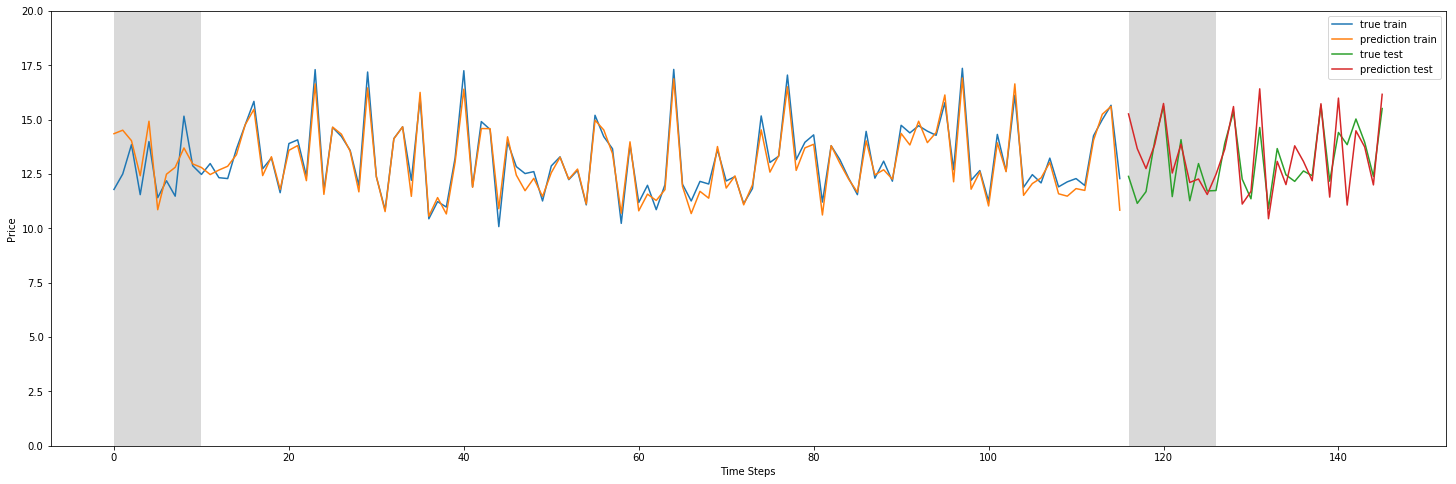

In [309]:
# Make the plotting-canvas bigger.
plt.figure(figsize=(25,8))
        
# Plot and compare the two signals.
plt.plot(t[:len(yTrain)], yTrain, label='true train')
plt.plot(t[:len(yTrain)], yPredRescaled1, label='prediction train')
plt.plot(t[len(yTrain):], yTest, label='true test')
plt.plot(t[len(yTrain):], yPredRescaled2, label='prediction test')
     
# Plot grey box for warmup-period.
p1 = plt.axvspan(0, warmUpSteps, facecolor='black', alpha=0.15)

# Plot grey box for warmup-period.
p2 = plt.axvspan(len(yTrain), (len(yTrain) + warmUpSteps), facecolor='black', alpha=0.15)

plt.ylim([0,20])

# Plot labels etc.
plt.xlabel('Time Steps') # in number of months
plt.ylabel('Price')
plt.legend()
plt.show()